# Revolut Challenge

## Days between Activity

### weaves

This notebook provides analysis for Part II - Engagedness measurement

It uses a local module rvlt which provides a data generation routine for an arbitrary PDF.

This version doesn't match my quoted results. The fit algorithm is very sensitive. I trimmed the tail from the data to just one year and the Inverse Gauss fits very well now. The Gamma is still mis-behaving. I still prefer the Wald but can no longer return the 11 day median and 30 day standard deviation.

In [1]:
import numpy as np
import pandas as pd
import math

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

import matplotlib
from cycler import cycler
import matplotlib.pyplot as plt

# this is the local Utility module
import rvlt

%load_ext autoreload
%autoreload 2

pd.__version__

'0.24.2'

In [2]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Tables to fetch from q/kdb+
tbls = ("ttdays0", "users2", "ntfs0", "ntfs1" )

In [4]:
# URL build function if fetching live data
urlf = lambda x: str.format("http://j1:4444/q.csv?{}", x)
# Or from the CSVs
urlf = lambda x: str.format("cache/out/x{}.csv", x)

In [5]:
# List for Excel - use text import and pass the URL as the filename (don't use web import)
[ urlf(x) for x in tbls]

['cache/out/xttdays0.csv',
 'cache/out/xusers2.csv',
 'cache/out/xntfs0.csv',
 'cache/out/xntfs1.csv']

In [6]:
# Fetch from source. Some checks and a clip
c = pd.read_csv(urlf(tbls[0]))
c.head()
data = pd.Series(c['x'], index=c['tdays0'])
data = pd.Series(c['x'])
data.head()
len(data)
all(data > 0.5)
# Trim some to get better stats.
data = data[0:365]
len(data)

,tdays0,x
0,1,170
1,2,937
2,3,1015
3,4,897
4,5,870


0     170
1     937
2    1015
3     897
4     870
Name: x, dtype: int64

607

True

365

<Figure size 864x576 with 0 Axes>

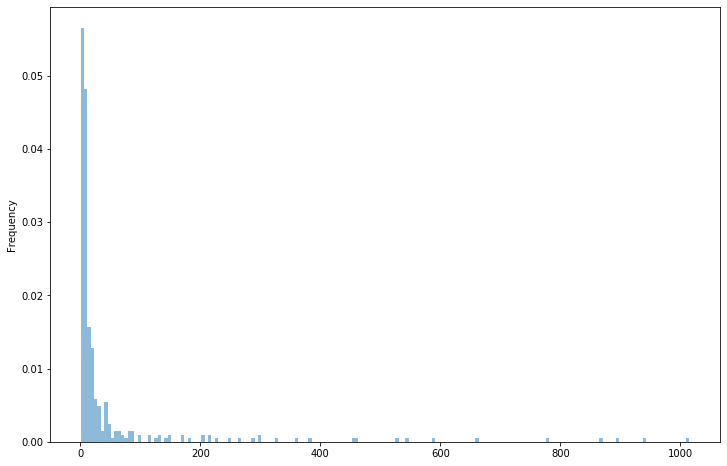

In [7]:
# Plot for comparison
bins=math.floor(len(data)/2)

plt.figure(figsize=(12,8))
data.plot(kind='hist', bins=bins, density=True, alpha=0.5)

## Distribution to fit

Individual users have an exponential distribution - days between events - so we try to find that distribution using a heuristics.

A sum of exponentials should be a Gamma distribution, but the fitted PDF is very strange. The stats are usable but not accurate enough.

The Wald is a close fit in shape, but doesn't sharpen from the origin quickly enough, so negative numbers appear. The inverse Gauss fits better, but doesn't have intuitive statistics.

A variety of long-tail pareto-like distributions have also been tried. They fit the data best. 
The commented numbers are the recorded SSE 

The best fit by SSE is the inverse Weibull (Frecht) but it has infinite mean and variance.

Note: this is very heuristic, one does need to view the PDF fit.

In [8]:
distribution = st.gamma # 0.008431213966169103 but a bizarre mis-fit

distribution = st.weibull_min # 0.026744602482763516
distribution = st.weibull_max # 0.11059876836774153
distribution = st.wald # 0.04321951887147501 good shape 0.004286143389295488
distribution = st.pareto # 0.004500105346672364 0.00030974282763696146 0.0004970887541559099
distribution = st.invgauss # 0.0042553838908376595 0.0003295758342573526 0.0006448498305976865
distribution = st.invweibull # 0.08741126234883718 0.00019755557973632042
distribution = st.genextreme # 0.04823740732286759 0.00019752473779033813
distribution = st.loglaplace # 0.013750924203496164 0.00011770092369544237
distribution = st.invweibull # 0.08741126234883718 0.00019755557973632042
distribution = st.invgauss # 0.000499322560600742 very good, but too sharp
distribution = st.wald # 0.004616067901700683 0.001556705204330918 good shape and fits well
# distribution = 

# These are the defaults
params = (0.0, 1.0)
sse = np.inf

In [9]:
# fit dist to data
params = distribution.fit(data)

# Separate parts of parameters
arg = params[:-2]
loc = params[-2]
scale = params[-1]
(arg, loc, scale)

((), -5.299462402268243, 37.274690823848516)

In [10]:
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0 # roll rotates the data

# Calculate fitted PDF and error with fit in distribution
# pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
pdf = distribution.pdf(x, *arg, loc=loc, scale=scale)
sse = np.sum(np.power(y - pdf, 2.0))
sse

0.001556705204330918

In [11]:
# My plot method for an arbitrary PDF returns a series "points of the PDF"
ppdf = rvlt.Utility().instance().make_pdf(distribution, params, ppfs=(0.0001, 0.95))
ppdf.head()
# Note. There shouldn't really be any negative numbers, but it helps the Wald to fit. The Gamma distribution
# is sharper but scikit.stats doesn't fit too well.

-3.104199    0.000406
-3.093526    0.000420
-3.082852    0.000434
-3.072179    0.000449
-3.061505    0.000464
dtype: float64

<Figure size 864x576 with 0 Axes>

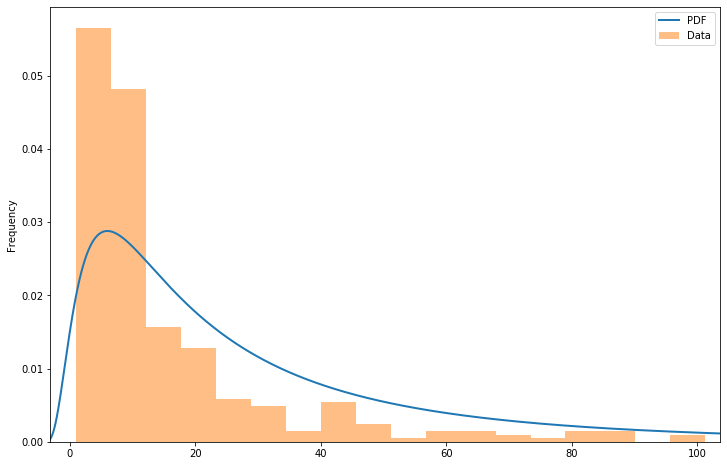

In [12]:
# Display - this is an extreme distribution, so it's best to trust the SSE number.
plt.figure(figsize=(12,8))
ax = ppdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

In [13]:
# The heavy-tailed distributions return negative mean and variance
# this indicates they are infinite.  The Wald has a good shape and has finite mean and variance.
(arg, loc, scale)
m1 = distribution.median(*arg, loc=loc, scale=scale)
m1
m1 = distribution.std(*arg, loc=loc, scale=scale)
m1
m0 = distribution.stats(*arg, loc=loc, scale=scale, moments='mvsk')
m0

((), -5.299462402268243, 37.274690823848516)

19.892313313507902

37.274690823848516

(array(31.97522842), array(1389.40257601), array(3.), array(15.))

In [14]:
?st.wald

Signature:       st.wald(*args, **kwds)
Type:            wald_gen
String form:     <scipy.stats._continuous_distns.wald_gen object at 0x7fa47c4b5c88>
File:            /misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A Wald continuous random variable.

As an instance of the `rv_continuous` class, `wald` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, loc=0, scale=1)
    Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
logsf(